In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit
from td_algorithm_funcs import get_prop_v2, get_prop_abs_v2, get_hists_v4, get_rate, simulate_traj
import pandas as pd

In [39]:
# k = 1
# tau = 0.5
# D = 1/2
# s = np.sqrt(2*D)
# N_t = 100
# dt = tau/4 if tau > 0 else 5e-2
# dx = 1/2
#sb = 20

k = 3
tau = 0.09
D = 1e-6
s = np.sqrt(2*D)
N_t = 50
dt = tau/4 if tau > 0 else 5e-2
dx = 3e-4 #1e-4
sb = 13*dx#0.005

f = 30
N_p = 8_000


ntau = round(tau/dt)
ts = np.arange(0,N_t)*dt
ts_r = ts[1:]


# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

# def force(x,*args):
#      return -k*x


def force(x,*args):
    return -k*x**3*1e6

i_zero = np.argmin(force(x_s)**2)

In [40]:
prop = get_prop_v2(x_s, force,D,dt,dx)
hists, unaltered_props, total_prob = get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop)

  0%|          | 0/50 [00:00<?, ?it/s]

Total number of final states: (24483,)


In [41]:
prop_abs = get_prop_abs_v2(x_s, force,D,dt,dx,  side='lr')
hists_abs, unaltered_props_abs, total_prob_abs = get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop_abs)

  0%|          | 0/50 [00:00<?, ?it/s]

Total number of final states: (22083,)


In [42]:
pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=0, force=force)
all_pos = pos[0]
sim_hists = np.stack([np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))])
sim_ts = np.arange(0, len(all_pos[0]))*dt/f -tau-dt

  0%|          | 0/1559 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

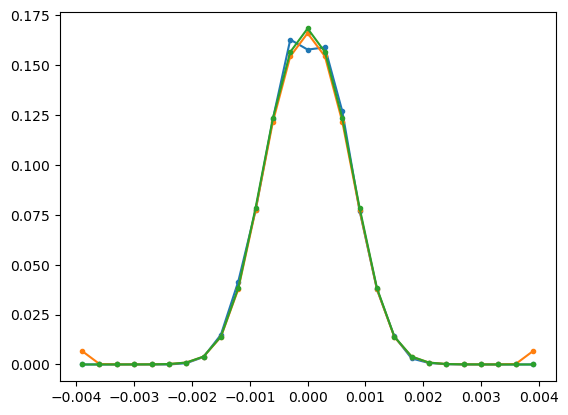

In [43]:
idx = 49
plt.plot(x_s,sim_hists[f*(idx+ntau+1)]/N_p,'.-')
plt.plot(x_s,hists[idx],'.-')
plt.plot(x_s,hists_abs[idx],'.-')

In [44]:
sim_var = np.var(pos, axis = 1)
sim_p = sim_hists[:,:]/np.sum(sim_hists, axis = 1)[:,None]
sim_hist_var = np.sum(sim_p*x_s[None,:]**2 - (sim_p*x_s[None,:])**2, axis = 1)

num_p = hists[:,:]/np.sum(hists, axis = 1)[:,None]
num_var = np.sum(num_p*x_s[None,:]**2 - (num_p*x_s[None,:])**2, axis = 1)

num_p_abs = hists_abs[:,:]/np.sum(hists_abs, axis = 1)[:,None]
num_var_abs = np.sum(num_p_abs*x_s[None,:]**2 - (num_p_abs*x_s[None,:])**2, axis = 1)

(0.0, 1e-06)

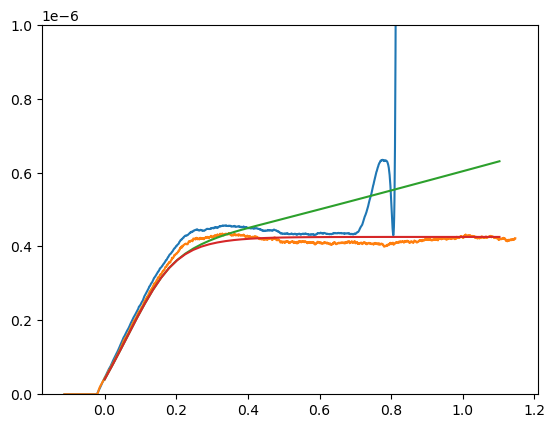

In [55]:
plt.plot(sim_ts,sim_var[0])
plt.plot(sim_ts,sim_hist_var)
plt.plot(ts, num_var)
plt.plot(ts, num_var_abs)
plt.ylim(0,1e-6)
#plt.xlim(0,4)

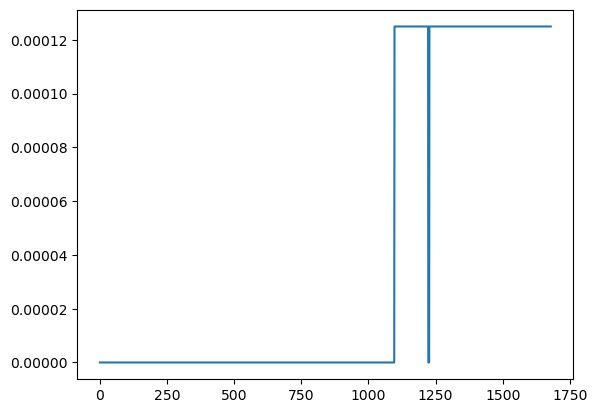

In [63]:
plt.plot(np.mean(pos[0]**2 > 1e-4, axis = 0))

In [46]:
np.max(all_pos)

2.8305214855724085e+79

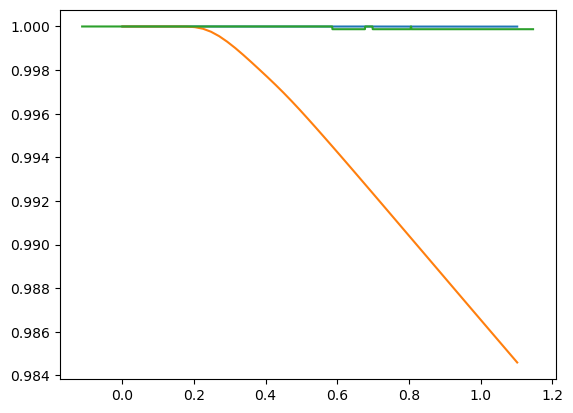

In [48]:
plt.plot(ts,np.cumprod(unaltered_props)[1:])
plt.plot(ts,np.cumprod(unaltered_props_abs)[1:])
plt.plot(sim_ts,np.sum(sim_hists, axis = 1)/N_p)

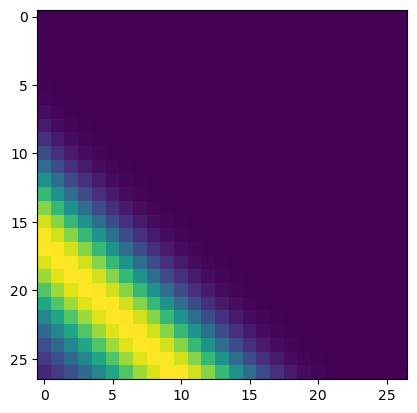

In [30]:
plt.imshow(prop_abs[16])

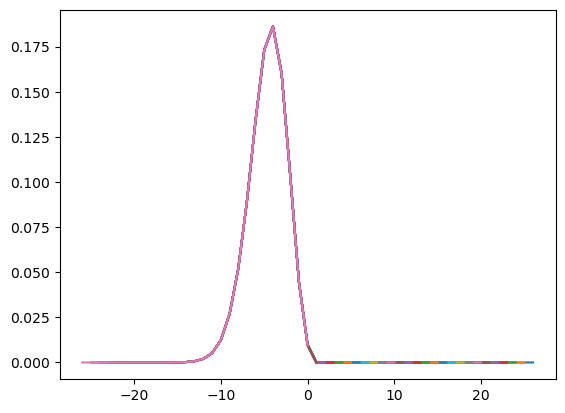

In [38]:
for i in range(N_x):
    plt.plot(np.arange(-i,-i+N_x),prop_abs[17,i])